# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

In [1]:
#!qbraid jobs enable haqs  # enable quantum jobs

In [2]:
TEAM_NAME = "RaFlaNeQ"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from scipy.optimize import minimize

 
import cvxopt as opt
from cvxopt import matrix, spmatrix, sparse
from cvxopt.solvers import qp, options
from cvxopt import blas

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [4]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [5]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

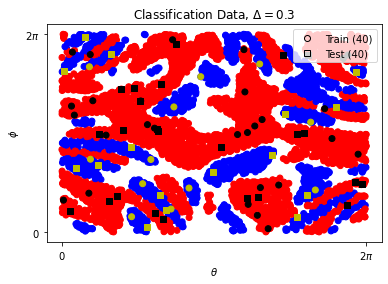

In [6]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

In [7]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [8]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

In [9]:
# functionality within the class as a attribute.
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [10]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    ## @pafloxy 
    for w in range(n_wires):
        qml.RZ(2 * x[w], wires= w)
    for w in pset:
        qml.CNOT(wires= w)
        qml.RZ(2 * x[2], wires= w[1])    
        qml.CNOT(wires= w)
    

## Quantum kernel (ideal)

In [11]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector
    
    Returns: |<0|feature_map(z)^daggered feature_map(x)|0>|^2 calculated via mat multiplication 

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [12]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

In [13]:
# evaluate k_ideal
# takes about a minute or two to evaluate completely
k_ideal = kernel_ideal(X_train, X_train)  

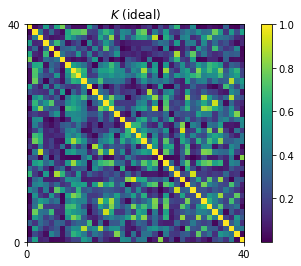

In [14]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)
im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

Ideally kernel matrix must be a positive semi-definite matrix ($\implies$ all its eigenvalues must be $\geq$ 0). However, either due to numerical error (in numerical simulations) or due to insufficient number of sampling (while obtaining kernel from by running the quantum circuit on an actual quantum hardware), it might not be exactly positive semi-definite. Below we investigate the same as follows:

1. We found those eigenvalues of kernel matrix *kernel_ideal* which are negative.
2. We then checked the magnitude of most negative eigenvalue.

Existence of negative eigen-values, though of very low magnitude, indicates that k_ideal is only approximately postive-definite, compared to machine-precision

In [15]:
## check properties of ideal kernel-matrix
negative_eigs = np.array([ np.linalg.eigvals(k_ideal)[i] for i in range(len(k_ideal)) if np.linalg.eigvals(k_ideal)[i] < 0 ])
max(np.abs(np.real(negative_eigs))), len(negative_eigs) 

(tensor(9.58012635e-16, requires_grad=True), 13)

## Quantum kernel estimator

Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol you will use a quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, you will sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$. Hence, to train, we maximize

\begin{equation}
L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),
\label{eq:Ld} \tag{1}
\end{equation}

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.

The training phase consists of the following steps:

---
### Algorithm 1: training
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.
---

In [16]:
#shots = 5000# I changed it to 5000

#dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)


#@qml.qnode(dev_est)

shots=5000
dev_check = qml.device('default.qubit', wires=2*n_wires)

@qml.qnode(dev_check)
def fidelity_estimate_circuit(x, z):
    # @Neel
    # experimental way of directly obtaining fiedelity between 2 states via SWAP test.
    
    """Circuit to estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    # TODO (hint: Havlicek Fig. 2.c.)

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)
    
    return qml.probs(wires=[0,1])

def fidelity_estimate(x,z):
    """Estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    probs=fidelity_estimate_circuit(x,z)
    return probs[0]# return empirica probability of sampling 00..0 

In [17]:
def kernel_experimental(A, B):
    """Experimentally estimated kernel matrix for sets A and B."""
    return np.array([[fidelity_estimate(i, j) for j in B] for i in A])

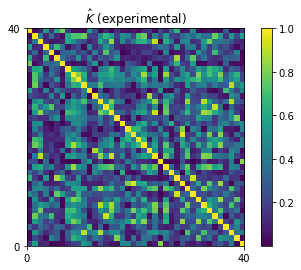

In [18]:
# estimate kernel matrix experimentally (by sampling all zero states, c.f. Havlicek Fig. 2.c. )
k_experimental = kernel_experimental(X_train, X_train)

# Visualize experimental kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (left)
im = plt.imshow(k_experimental, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")
plt.show()

Similarly here we check the corresponding properties of the kernel obtained from the experiment,

In [19]:
## check properties of experimental kernel-matrix
negative_eigs = np.array([ np.linalg.eigvals(k_experimental)[i] for i in range(len(k_experimental)) if np.linalg.eigvals(k_experimental)[i] < 0 ])
min(np.abs(np.real(negative_eigs))), len(negative_eigs) ## existence of low magnitude negative eigen-values indicate that k_experimental is only approximately postive-definite, compared to machine-precision

(tensor(6.61273124e-18, requires_grad=True), 13)

Next we make an comparison between the ideal kernel `k_ideal` and `k_experimental`, by checking the properties of the *Frobenius Inner Product* of their difference 

$$                      \mathbf{f(\hat{K}_{ideal}-\hat{K}_{exp})} = \mathbf{Tr}\left( \left(\hat{K}_{ideal}-\hat{K}_{exp}\right)^{T}\left(\hat{K}_{ideal}-\hat{K}_{exp}\right) \right)
$$

Lower the value of **f**, closer the both matrices are to each other. Also we can check the magnitude of the largest eigenvalue of $\mathbf{\hat{K}_{ideal}-\hat{K}_{exp}}$, which should be close to zero if the matrices match up to certain degree.


In [20]:
## Compare k_experimental against k_ideal
diff = k_experimental - k_ideal
qml.math.frobenius_inner_product(diff,diff) , np.real(np.linalg.eigvals(diff))[0]  ## check the norm of the 'diff' as well as its largest eigenvalue

(tensor(0., requires_grad=True), tensor(0., requires_grad=True))

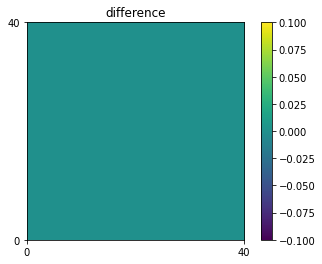

In [21]:
im = plt.imshow(diff, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("difference")
plt.show()

For the next phase of the problem, we are required to frame an quadratic optimisation problem $\mathbf{L_{D}}$ in terms of the parameters $\mathbf{ \{ \alpha_1, \alpha_2, . . .\alpha_n \} }$, basing which we can proceed to classify any given data. For that purpose we design the `support_vector_classifier` class which can be used to find the optimal set $\mathbf{ \{\alpha_i \}}$ as well as to predict on any given input.

In [22]:
from typing import Callable# might be deprecated for the latest version. 
class support_vector_classifier():
    """
    A class to implement SVC for the given classification problem  
    
    """

    def __init__(self, fidelity_calc_fun: Callable ) -> None :
        
        self.fidelity_estimate = fidelity_calc_fun ## function to calculate fidelity between elements
    
    def find_kernel_matrix(self, A, B) -> np.array :
        """ 
        Calculates elements of the kernel matrix for the given inputs
        """

        return np.array([[self.fidelity_estimate(i, j) for j in B] for i in A])
        

    def train_svc(self, x_train: np.array, y_train: np.array):
        """
        Formulates the Dual problem to find necessary coefficents and solves it using 'cvxopt' tools

        ARGS:
        ----
        x_train : an array containing all training data (X)
        y_train : an array containing all training labels (Y)


        RETURNS:
        -------
        support_vec_indices : array containing indices of the 'x_train' that correspond to the support vectors
        support_vec_alphas : array of positive 'alpha' coefficient corresponding to the support vectors 
        support_vec_ : array of support vectors
        b_estimates : estimate 'b' parameter for the classification step
        
        """
        ## load trainig data ##
        self.x_train = x_train
        self.y_train = y_train
        self.training_set_size = len(y_train)

        n = self.training_set_size

        self.kernel_matrix = self.find_kernel_matrix(x_train, x_train)
        quadratic_term = np.zeros((n,n))

        print(self.kernel_matrix) ## checkflag
        ## formulate quadratic problem ##
        for i in range(n):
            for j in range(n):
                quadratic_term[i,j] = self.kernel_matrix[i,j] * self.y_train[i] * self.y_train[j]

        quadratic_term = (0.5) * quadratic_term     ## quadrtic term
        linear = -1 * np.ones(n)        ## linear term

        A = matrix(self.y_train).T  ## add constraints
        B = matrix(0.0)
        G = matrix(-1* np.eye(n))  ## add constraints
        H = matrix(np.zeros(n))

        sol = qp(matrix(quadratic_term), matrix(linear), G, H, A, B)

        alphas = np.array(sol['x'])

        ## extract information regarding support vectors ##
        c = 0.00001  # TODO: make this inequality param tunable
        self.support_vec_indices = [ i for i in range(len(alphas)) if alphas[i] > c]
        self.support_vec_alphas =  [ (i, alphas[i]) for i in range(len(alphas)) if alphas[i] > c ] 
        self.support_vec_ =  [ (i, self.x_train[i]) for i in range(len(alphas)) if alphas[i] > c ] 
        
        ## estimate 'b' parameter for the classifier ##
        b_estimates = [y_train[j] - np.sum([ self.y_train[i] * alphas[i] * self.fidelity_estimate(self.x_train[i] , self.x_train[j]) for i in range(n)]) for j in self.support_vec_indices] 
        self.b = np.mean(b_estimates)

        return self.support_vec_indices, self.support_vec_alphas, self.support_vec_, b_estimates

    def predict_svc(self, x_test_elem):
        """ 
        Function to predict class of given input 

        ARGS:
        ----
        x_test_elem  :  single input data 

        
        RETURNS:
        -------
        y_label_elem : predicted output label

        """
        estimate = np.sum([  self.y_train[index] * alpha * self.fidelity_estimate(self.x_train[index], x_test_elem) for index, alpha in self.support_vec_alphas ]) + self.b
        y_label_elem = np.sign(estimate)

        return y_label_elem

        

We train the `support_vector_classifier` on both the ideal and the experimental kernel calculating functions and use them to make predictions on the test set.

In [23]:
svc_exp = support_vector_classifier(fidelity_estimate) ## train using experimental kernel estimator
res_exp = svc_exp.train_svc(X_train, Y_train)

prediction_exp = [(svc_exp.predict_svc(X_test[j]) == Y_test[j] ) for j in range(len(Y_test))]
acc_exp = prediction_exp.count(True) / len(Y_test) * 100
print(f"Prediction accuracy is: {acc_exp}%.")  ## takes around 2 min

[[1.         0.02500642 0.10044942 ... 0.01871764 0.01224976 0.17125913]
 [0.02500642 1.         0.40795046 ... 0.54705393 0.22408076 0.56019322]
 [0.10044942 0.40795046 1.         ... 0.28483832 0.12851009 0.09452825]
 ...
 [0.01871764 0.54705393 0.28483832 ... 1.         0.37267765 0.41112766]
 [0.01224976 0.22408076 0.12851009 ... 0.37267765 1.         0.01843631]
 [0.17125913 0.56019322 0.09452825 ... 0.41112766 0.01843631 1.        ]]
     pcost       dcost       gap    pres   dres
 0: -1.0099e+01 -2.8901e+01  9e+01  7e+00  2e+00
 1: -1.3190e+01 -2.6942e+01  2e+01  8e-01  2e-01
 2: -1.7877e+01 -2.3523e+01  6e+00  2e-01  5e-02
 3: -2.0614e+01 -2.1497e+01  9e-01  9e-03  2e-03
 4: -2.1131e+01 -2.1195e+01  6e-02  5e-04  1e-04
 5: -2.1171e+01 -2.1174e+01  3e-03  1e-05  3e-06
 6: -2.1173e+01 -2.1173e+01  2e-04  8e-08  2e-08
 7: -2.1173e+01 -2.1173e+01  3e-06  7e-10  2e-10
Optimal solution found.
Prediction accuracy is: 10000.0%.


In [24]:
svc_ideal = support_vector_classifier(kernel) ## train using ideal kernel estimator
res_ideal = svc_ideal.train_svc(X_train, Y_train)

prediction_ideal = [(svc_ideal.predict_svc(X_test[j]) == Y_test[j] ) for j in range(len(Y_test))]
acc_ideal = prediction_ideal.count(True) / len(Y_test) * 100
print(f"Prediction accuracy is: {acc_ideal*1}%.")   ## takes around 2 min

[[1.         0.02500642 0.10044942 ... 0.01871764 0.01224976 0.17125913]
 [0.02500642 1.         0.40795046 ... 0.54705393 0.22408076 0.56019322]
 [0.10044942 0.40795046 1.         ... 0.28483832 0.12851009 0.09452825]
 ...
 [0.01871764 0.54705393 0.28483832 ... 1.         0.37267765 0.41112766]
 [0.01224976 0.22408076 0.12851009 ... 0.37267765 1.         0.01843631]
 [0.17125913 0.56019322 0.09452825 ... 0.41112766 0.01843631 1.        ]]
     pcost       dcost       gap    pres   dres
 0: -1.0099e+01 -2.8901e+01  9e+01  7e+00  2e+00
 1: -1.3190e+01 -2.6942e+01  2e+01  8e-01  2e-01
 2: -1.7877e+01 -2.3523e+01  6e+00  2e-01  5e-02
 3: -2.0614e+01 -2.1497e+01  9e-01  9e-03  2e-03
 4: -2.1131e+01 -2.1195e+01  6e-02  5e-04  1e-04
 5: -2.1171e+01 -2.1174e+01  3e-03  1e-05  3e-06
 6: -2.1173e+01 -2.1173e+01  2e-04  8e-08  2e-08
 7: -2.1173e+01 -2.1173e+01  3e-06  7e-10  2e-10
Optimal solution found.
Prediction accuracy is: 10000.0%.


We also compare the classification accuracy obtained by us against the `sklearn.svm`'s `SVC` module which has inbuilt funtionaliteis to train and predict.

In [25]:
svc_sklrn = SVC(kernel= kernel_experimental, C = 100000.0)
svc_sklrn = svc_sklrn.fit(X_train, Y_train)

prediction_sklrn = svc_sklrn.predict(X_test)
prediction_sklrn = [ prediction_sklrn[i]==Y_test[i] for i in range(len(Y_test))]
acc_sklrn = accuracy_score( prediction_sklrn, Y_test, normalize = True )
print(f"Prediction accuracy is: {acc_sklrn*100}%.")    ## takes around 3 min

Prediction accuracy is: 60.0%.


In the classification phase, we want to assign a label to a new datum $s \in S$ of the test set. For this, the inner products $K(\textbf{x}_i, \textbf{s})$ between all support vectors $\textbf{x}_j \in T$ with $\alpha_i^* > 0$ and the new datum s have to be estimated on the quantum computer, c.f. Havlicek Fig. S5.b. The new label $\tilde{m}(\textbf{s})$ for the datum is assigned according to Havlicek eqn. (14). Since all support vectors are known from the training phase and we have obtained access to the kernel $K(\textbf{x}_i,\textbf{s})$ from the quantum hardware, the label can be directly computed according to


\begin{equation}
\tilde{m}(\textbf{s}) = \text{sign} \bigg(\sum_{i=1}^t y_i \alpha_i^* K(\textbf{x}_i, \textbf{s}) + b \bigg).
\label{eq:ms} \tag{2}
\end{equation}

Note that the bias $b$ in $\tilde{m}(\textbf{s})$ can be calculated from the weights $\alpha_i^*$ by choosing any $i$ with $\alpha_i^* > 0$ and solving $\sum_j y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i) + b = y_i$ for $b$.

---
### Algorithm 2: classification
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.
---

We can also compare the support vectors found by each of the three methods discussed above. Below we return the index of the training vectors in the input data set that form the support.

In [26]:
set(svc_sklrn.support_), set(res_ideal[0]), set(res_exp[0])

({9, 10, 16, 17, 18, 20, 24, 29, 30, 38},
 {9, 10, 16, 17, 18, 20, 24, 26, 29, 30, 37, 38},
 {9, 10, 16, 17, 18, 20, 24, 26, 29, 30, 37, 38})

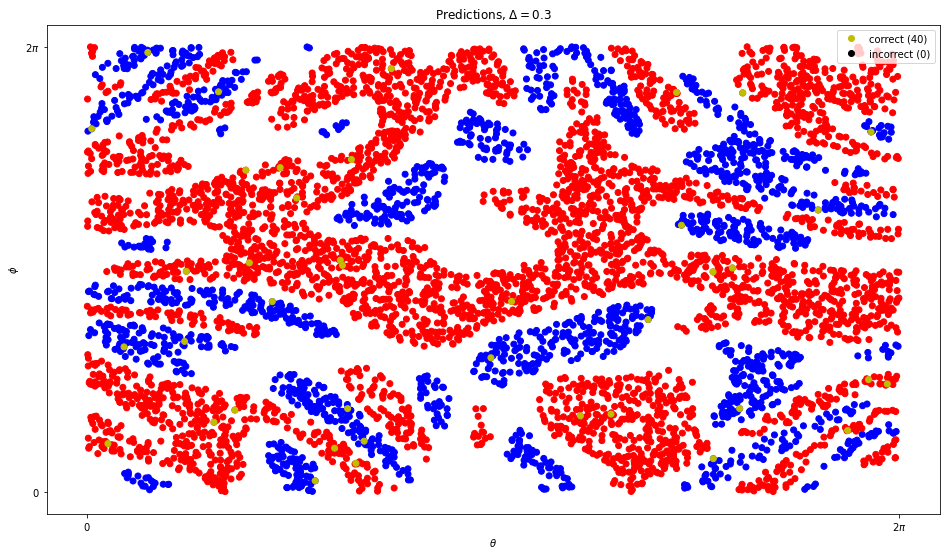

In [31]:
preds = prediction_exp   # change with {prediction_exp, prediction_sklrn , prediction_ideal}
n_correct = preds.count(True)
n_incorrect = preds.count(False)

# Plot predictions
# preds_png = f"{VQC_OUT}/{TEAM_NAME}_preds.png"

label_correct = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="y",
    markeredgecolor="y",
    label=f"correct ({n_correct})",
)
label_incorrect = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    label=f"incorrect ({n_incorrect})",
)

plt.figure(figsize=(16,9))
plt.scatter(xi, xj, marker="o", c=["r" if v == 1 else "b" for v in Ys])
plt.scatter(xi_test, xj_test, c=["y" if v == True else "k" for v in preds])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_correct, label_incorrect], loc="upper right")
plt.title(f"Predictions, $\Delta = {delta}$")
# plt.savefig(preds_png)
plt.show()

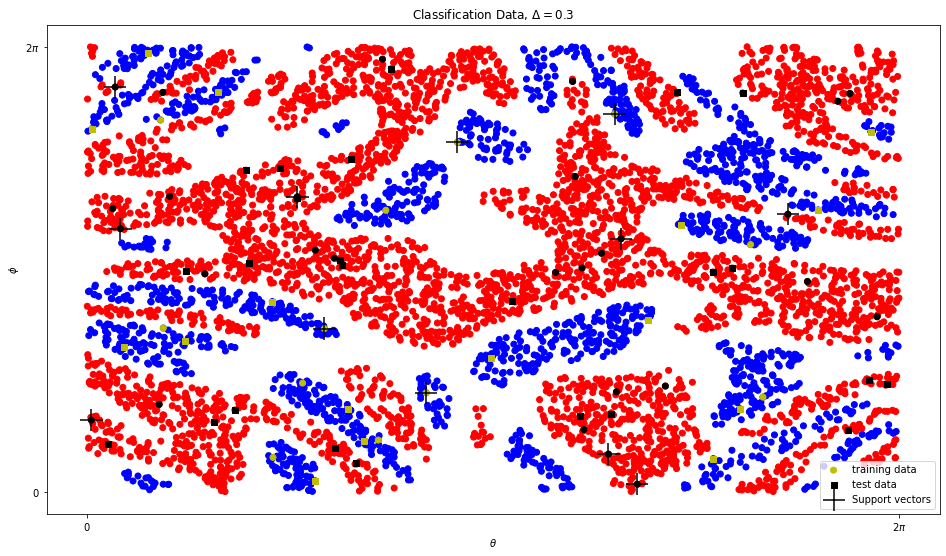

In [30]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]
xi_sv , xj_sv = split_xs([X_train[i] for i in res_exp[0] ])  ## change res_exp[0] with {res_exp[0], res_exp[1], svc_sklrn.support_  }

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.figure(figsize=(16,9))
plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train], label="training data")
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test], label="test data")
plt.scatter(xi_sv, xj_sv, s= [500]*len(xj_sv) , marker="+", c = "k", label="Support vectors" )  ## the green markers indicate the support-vectors
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
#plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.legend()
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()